# Canny Edge Detection 
Canny edge detection is a multistage edge detection algorithm that takes grayscale images and was developed by John F. Canny [1] [2].
1) Gaussian blurring is applied to reduce noise 
2) Calculate the intensity gradient of the image. This is done with a Sobel kernel filter calculating the gradient of the image in the vertical and horizontal direction. It measures how the intensity changes in eahc of the directions. The magnitude of the directional gradient of each pixel can be found using: $$ G = \sqrt{G_x^2 + G_y^2} $$ And the corresponding direction using: $$ \theta = \arctan\left(\frac{G_y}{G_x}\right) $$
3) Non-maximum Supression. This is used to remove pixels that aren't part of the edge essentialy thining out the edges. It works by checking if a pixel "is a local maximum in its neighborhood in the direction of gradient" [1]. If so, the pixel is kept otherwhise it is set to zero.
4) Double thresholding and Hysteresis edge tracking. To determine which edges in the picture after step 3 are actually edges, we apply double thresholding. We define two threshold values: one upper and one lower value. Pixels that are above the upper threshold are defined to be strong edges, and pixels that are below the threshold are completely discarded. Pixel values in between are defined to be weak edges, if they are connected to strong edges we keep them, otherwhise discard them.

*Based on the explanation from [1] and [3].*

# Preprocessing:
Before applying the Canny edge detector, images need to be converted from BGR to grayscale.
Optionaly downscaling will also be an option for large images.

downscaling done
Downscaling done: 3072x4080 → 1536x2040


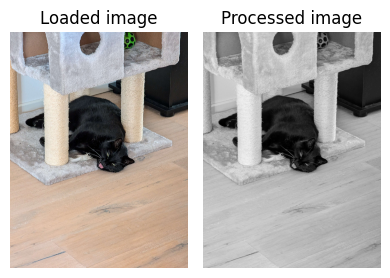

In [4]:
import matplotlib.pyplot as plt 
import importlib
import numpy as np
import cv2

image_path = input("enter the path to the image you want to process: ")
imageBGR = cv2.imread(image_path)
imageRGB = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2RGB)
processed_img = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY) 

if processed_img is None:
    raise ValueError("image not found")

downscale_to_50_percent = input("do you want to downscale the image to 50%? (y/n): ")
if downscale_to_50_percent.lower() == "y":
    height, width = processed_img.shape[:2]
    new_width = int(width * 0.5)
    new_height = int(height * 0.5)
    processed_img = cv2.resize(processed_img, (new_width, new_height), interpolation = cv2.INTER_AREA)
    print("downscaling done")
    print(f"Downscaling done: {width}x{height} → {new_width}x{new_height}")

#show original and preprocessed image
fig, (im1, im2) = plt.subplots(1,2, figsize = (4, 3))

im1.imshow(imageRGB)
im1.set_title("Loaded image")
im1.axis("off")

im2.imshow(processed_img, cmap = "gray")
im2.set_title("Processed image")
im2.axis("off")

plt.tight_layout()
plt.show() 

### References

[1] OpenCV. (n.d.). *Canny Edge Detection*. OpenCV Documentation. Retrieved April 1, 2025, from https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

[2] Fisher, R. B. (n.d.). *Canny Edge Detection*. HIPR2 - Image Processing Learning Resources. Retrieved April 1, 2025, from https://homepages.inf.ed.ac.uk/rbf/HIPR2/canny.htm

[3] Liang, J. (n.d.). *Canny Edge Detection*. Retrieved April 1, 2025, from https://justin-liang.com/tutorials/canny/